In [5]:
# imports and functions, does nothing

from IPython.display import Image
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from json import JSONEncoder
import json

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def serialize(uri, o, version=''):
    try:
        os.remove(uri)
    except:
        pass
    with open(uri, "w") as f:
        if version != '':
            f.write('#version: '+version+'\n')
        json.dump(o, f, cls=NumpyArrayEncoder)

def deserialize(uri, version=''):
    if os.path.isfile(uri):
        with open(uri, "r") as f:
            data = []
            for line in f:
                if not line.startswith('#version:'):
                    data.append(line)
            return json.loads(''.join(data))
    return None

def load_or_compute(uri, compute_function, rebuild=False):
    data = None
    if not rebuild:
        data = deserialize(uri)
    if data is None:
        data = compute_function()
        serialize(uri, data)
        return data
    return data

def img(path, width=400):
    rnd = random.randint(0,2e9)
    return f"""<img src="{path}?nocache={rnd}" style="width:{width}px; "></img>"""

def plot_fi(features_of_interest, title):
    features_of_interest.sort(key=lambda row: row[1], reverse=True) # truncate top ten
    features_of_interest = features_of_interest[:10]
    features_of_interest.sort(key=lambda row: row[1], reverse=False) # plotting needs ascending order

    xs = [x[0] for x in features_of_interest]
    ys = [y[1] for y in features_of_interest]
    yerr = [[min(y[1], y[2]) for y in features_of_interest], [y[2] for y in features_of_interest]]

    plt.barh(xs, ys, xerr=yerr)
    plt.title(title)
    plt.show()

In [6]:
data_all = np.load('datasets/quic-100p-150-40runs.npy', allow_pickle=True).item()
data = data_all['nofilter'] # adblock + decentraleyes
urls = [url for url in data]

# total incoming size
def add(a, b):
    x = 0
    if a is not None:
        x += abs(a)
    if b is not None:
        x += abs(b)
    return x

def toOldHARFormat(data):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                domain, fullurl, t, out_h, out_b, t_resp, inc_h, inc_b = request
                data2[url][sample].append([t, add(out_h, out_b), add(inc_h, inc_b)])
    return data2


data_notimings = {}
for url in data:
    data_notimings[url] = {}
    for sample in data[url]:
        data_notimings[url][sample] = []
        for request in data[url][sample]:
            domain, fullurl, t, out_h, out_b, t_resp, inc_h, inc_b = request
            data_notimings[url][sample].append([domain, fullurl, 0, out_h, out_b, 0, inc_h, inc_b ])


data_old_format = toOldHARFormat(data)
data_old_format_noprotections = toOldHARFormat(data_all['nofilter'])

In [7]:
from lib.features import *
from lib.rf import *

def get_estimate_stats(result):
    
    random_guess = []
    min_estimate = []
    last_estimate = []
    
    for k, v in result.items():
        random_guess.append(v['random-guessing'])
        min_estimate.append(v['min-estimate'])
        last_estimate.append(v['last-estimate'])
        
    return min_estimate, last_estimate, random_guess


Queries: median 14785.0 max 126557 
Responses: median 768172.0 max 9324936 


Text(0, 0.5, 'Total Incoming [B]')

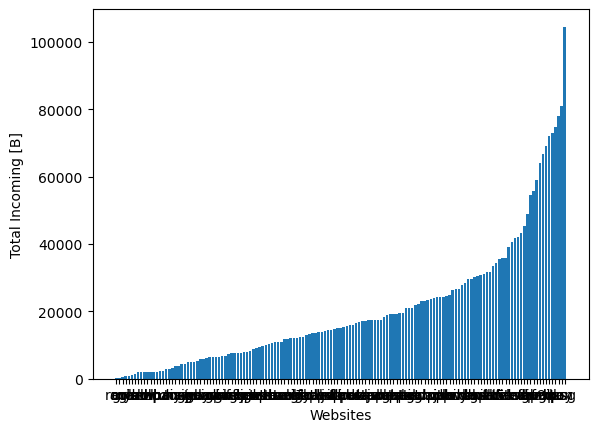

In [8]:
# total incoming size
incoming_bytes = []
incoming_bytes_per_website = dict()
incoming_bytes_per_website_noprotection = dict()

tot_queries = []
tot_responses = []

for url in data_old_format:
    outgoing_bytes_this_website = []

    for sample in data_old_format[url]:
        query = 0
        response = 0

        outgoing_bytes_this_sample = 0
        for request in data_old_format[url][sample]:
            t, out, inc = request
            outgoing_bytes_this_sample += out
            query += out
            response += inc
            incoming_bytes.append(inc)

        tot_queries.append(query)
        tot_responses.append(response)
        outgoing_bytes_this_website.append(outgoing_bytes_this_sample)

    if len(outgoing_bytes_this_website) > 0:
        incoming_bytes_per_website[url] = [np.mean(outgoing_bytes_this_website), np.std(outgoing_bytes_this_website)]


print(f"Queries: median {np.median(tot_queries)} max {np.max(tot_queries)} ")
print(f"Responses: median {np.median(tot_responses)} max {np.max(tot_responses)} ")

tuples = list(incoming_bytes_per_website.items())
tuples.sort(key=lambda row: row[1])

xs = [t[0][:3] for t in tuples]
ys = [int(t[1][0]) for t in tuples]

plt.bar(np.arange(len(ys)), ys)
plt.xticks(np.arange(len(ys)), xs)
plt.xlabel('Websites')
plt.ylabel('Total Incoming [B]')
#plt.yscale('log')
#plt.ylim([0, 10000])

Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123
[feature_extract] Number of features 12

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.95890796328386 but were corrected to 0.8306033766472871.
Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9511118763270843 but were corrected to 0.8238504280861365.
Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9516689126803904 but were corrected to 0.8243329314062536.
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.951400002834723 but were corrected to 0.8241000024554291.
Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9614518165488489 but were corrected to 0.8328068551796368.
Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9475013973220573 but were corrected to 0.8207230413423454.
Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9486419261168185 but were corrected to 0.8217109641716104.
Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9589315699109554 but were corrected to 0.8306238246411796.
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9521259560355687 but were corrected to 0.824728821073063.
{'score': {'accuracy': (0.9343934040047113, 0.004800396671923408), 'precision': (0.8317263937158303, 0.004115020205664465), 'recall': (0.8268368544600939, 0.0038838703399932876), 'f1score': (0.8260097074964842, 0.0038490444243647033)}, 'features': [('bytes_incoming', 0.1286724537003897, 0.0048736758807739955), ('bytes_total', 0.12361453776378575, 0.004185567413108952), ('bytes_%_in', 0.11560682358692147, 0.0032948833787672317), ('bytes_%_out', 0.11371015143285781, 0.0028744699327644123), ('bytes_outgoing', 0.11766529585801092, 0.0036514691982286636), ('hist_2006', 0.08493399547688363, 0.002968452569898735), ('n_total', 0.08133082271755895, 0.007075978736087128), ('n_outgoing', 0.0728994268798227, 0.024608812293569378), ('hist_1672', 0.05448349624077929, 0.03569054410717205), ('n_incoming', 0.07028734151153301, 0.02410544440731296), ('time_p25', 0.008074884548701351, 0.02422465364610405), ('ti

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


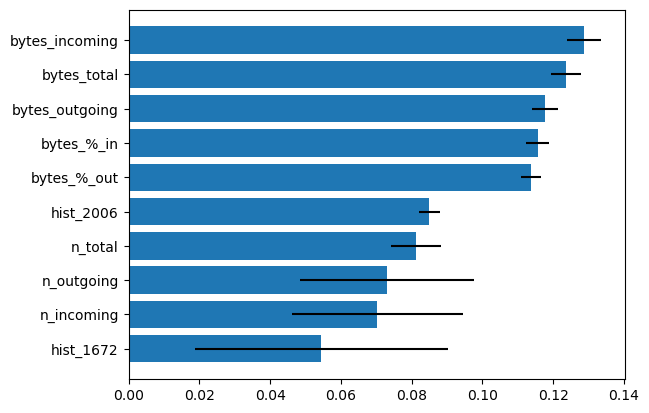

In [9]:
#baseline on HARs
features = get_features(data_old_format)
clf_res = rf_with_rfe(features, n_classes=141)
print(clf_res)
plot_fi(clf_res['features'], title="")

Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123
[feature_extract] Number of features 12

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9623693937180308 but were corrected to 0.8336016579388575.
Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9644383274942815 but were corrected to 0.8353937625478637.
Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9551378917591257 but were corrected to 0.827337751312482.
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9606308286006996 but were corrected to 0.8320957177315919.
Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9530351415611553 but were corrected to 0.8255163550142403.
Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9538507430186053 but were corrected to 0.8262228266992144.
Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9486419261168185 but were corrected to 0.8217109641716104.
Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9652365117214471 but were corrected to 0.836085147477028.
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141 but only found 123
Scores were 0.9572739843184606 but were corrected to 0.8291880286702159.
{'score': {'accuracy': (0.9386336866902237, 0.005331670340521216), 'precision': (0.8353735290531066, 0.004442193826364415), 'recall': (0.8305918846411805, 0.0046072159955942455), 'f1score': (0.83020399372959, 0.004666738543804266)}, 'features': [('bytes_incoming', 0.12436178237202518, 0.005682291687588504), ('bytes_total', 0.12243576201014887, 0.005069686749599236), ('bytes_outgoing', 0.11921298190917654, 0.004921965552403222), ('bytes_%_in', 0.11043437549355037, 0.004034832491966439), ('bytes_%_out', 0.11011222305649089, 0.005651594380735386), ('n_total', 0.0693218383669463, 0.03498477710568565), ('n_outgoing', 0.08102990511365828, 0.028221766990018018), ('hist_2006', 0.07605473628164748, 0.02549138988397013), ('hist_2341', 0.05492273424636753, 0.03598672257463661), ('hist_1672', 0.06714151380427318, 0.02266713110740253), ('n_incoming', 0.05841001960951033, 0.03901455053401908), ('hist_1003

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


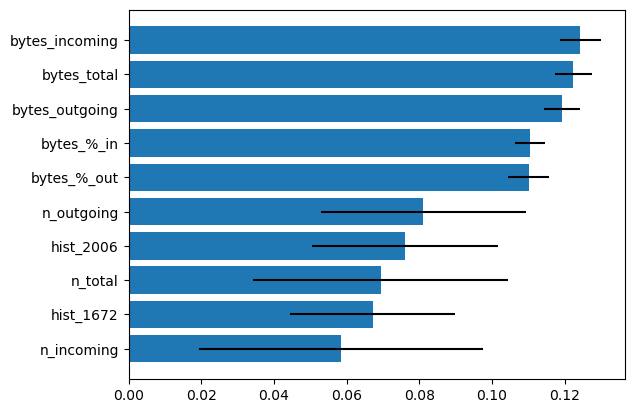

In [10]:
#without timings

data_no_timings = dict()
for url in data_old_format:
    data_no_timings[url] = dict()
    for sample in data_old_format[url]:
        data_no_timings[url][sample] = []
        for t, out, inc in data_old_format[url][sample]:
            data_no_timings[url][sample].append([0, out, inc])

features = get_features(data_no_timings)
clf_res = rf_with_rfe(features, n_classes=141)
print(clf_res)
plot_fi(clf_res['features'], title="")

max query 55523
{'ys': [186, 335, 483, 779, 784, 988, 1282, 1868, 1963, 1979, 2015, 2066, 2106, 2106, 2181, 2422, 2890, 2896, 3075, 3672, 3828, 4244, 4269, 4855, 4987, 5044, 5305, 5825, 5871, 6279, 6303, 6422, 6432, 6483, 6717, 6736, 7192, 7584, 7597, 7609, 7612, 7807, 7833, 8102, 8934, 9205, 9422, 9801, 9947, 10332, 10496, 10864, 10890, 10948, 11675, 11906, 11967, 12032, 12069, 12296, 12518, 12869, 13197, 13496, 13546, 13827, 13895, 14212, 14454, 14595, 14819, 15036, 15109, 15372, 15574, 15832, 15977, 16597, 16824, 17023, 17265, 17435, 17451, 17454, 17479, 17516, 18191, 18904, 19249, 19290, 19306, 19364, 19406, 20987, 21022, 21036, 21757, 22119, 22970, 23094, 23436, 23556, 23850, 24141, 24227, 24257, 24554, 24901, 26387, 26492, 26508, 27706, 28261, 29481, 29535, 30087, 30342, 30863, 31055, 31552, 31623, 33359, 34293, 35412, 35722, 35737, 39179, 40597, 41807, 42185, 43173, 45429, 48918, 54395, 55626, 58989, 64151, 66761, 69199, 72073, 72781, 74813, 78110, 81034, 104464], 'ys_err': [217

Text(0, 0.5, 'Total Outgoing [B]')

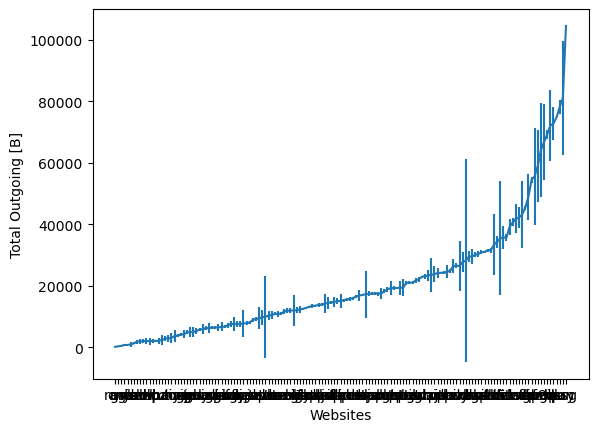

In [11]:
# total outgoing size

max_query = 0

outgoing_bytes_per_website = dict()
outgoing_bytes_per_website2 = dict()

for url in data_old_format:
    outgoing_bytes_this_website = []
    outgoing_bytes_this_website2 = []

    for sample in data_old_format[url]:
        outgoing_bytes_this_sample = 0
        outgoing_bytes_this_sample2 = 0
        for request in data_old_format[url][sample]:
            t, out, inc = request
            outgoing_bytes_this_sample += out
            outgoing_bytes_this_sample2 += 1400
            if out > max_query:
                max_query = out

        outgoing_bytes_this_website.append(outgoing_bytes_this_sample)
        outgoing_bytes_this_website2.append(outgoing_bytes_this_sample2)

    if len(outgoing_bytes_this_website) > 0:
        outgoing_bytes_per_website[url] = [np.mean(outgoing_bytes_this_website), np.std(outgoing_bytes_this_website)]
        outgoing_bytes_per_website2[url] = np.mean(outgoing_bytes_this_website2)

print(f"max query {max_query}")

tuples = list(outgoing_bytes_per_website.items())
tuples.sort(key=lambda row: row[1])

xs = [t[0][:3] for t in tuples]
ys = [int(t[1][0]) for t in tuples]
ys_err = [int(t[1][1]) for t in tuples]

tuples2 = list(outgoing_bytes_per_website2.items())
tuples2.sort(key=lambda row: row[1])
ys2 = [int(t[1]) for t in tuples2]

plot_data = dict(ys=ys, ys_err=ys_err)
print(plot_data)

#plt.bar(np.arange(len(ys)), ys2, label="padded queries")
plt.errorbar(np.arange(len(ys2)), ys, yerr=ys_err, label="standard queries")

plt.xticks(np.arange(len(ys)), xs)
plt.xlabel('Websites')
plt.ylabel('Total Outgoing [B]')
#plt.yscale('log')
#plt.ylim([0, 10000])

In [12]:
# compute optimal padding functions based on incoming sizes

incoming_bytes.sort()
incoming_bytes = [x for x in incoming_bytes if x > 2] # 0 and 1 are special case that correspond to blocked resources

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def find_cost(data, padding_function_steps):
    costs = []
    # data is sorted, so i is never decreasing
    i = 0
    for x in data:
        pad_to = padding_function_steps[i]
        while x > pad_to:
            i += 1
            pad_to = padding_function_steps[i]
        costs.append(pad_to - x)
    return costs


def find_optimal_pad(data, n_cut): # data must be sorted
    size_of_cut = math.ceil(len(data) / n_cut)
    chunked = chunks(data, size_of_cut)
    cuts = [chunk[-1] for chunk in chunked]
    costs = find_cost(data, cuts)

    return cuts, np.median(costs), np.mean(costs)

def build_padding_functions():
    padding_functions = []
    prev_n_cuts = -1
    for cut in range(1, 50):
        cuts, med_cost, mean_cost = find_optimal_pad(incoming_bytes, cut)
        if len(cuts) == prev_n_cuts:
            continue
        prev_n_cuts = len(cuts)
        padding_functions.append([cuts, med_cost, mean_cost])
    return padding_functions

padding_functions = load_or_compute("pad_fn.npy", build_padding_functions, rebuild=True)

for cut, med_cost, mean_cost in padding_functions:
    print(med_cost, cut)


6615527.5 [6625482]
9778.0 [9954, 6625482]
10909.0 [4596, 20874, 6625482]
6136.0 [3068, 9955, 29140, 6625482]
4549.5 [2518, 6226, 16518, 36256, 6625482]
3690.0 [2281, 4596, 9955, 20874, 42208, 6625482]
2878.0 [2156, 3645, 7083, 14218, 23804, 47211, 6625482]
2542.0 [2044, 3068, 5751, 9955, 17429, 29140, 52131, 6625482]
2412.0 [1934, 2743, 4596, 7783, 13154, 20874, 33054, 56882, 6625482]
1935.0 [1829, 2518, 3894, 6226, 9955, 16518, 22934, 36256, 63986, 6625482]
1751.0 [1756, 2401, 3409, 5309, 8168, 12637, 18055, 25434, 38741, 71072, 6625482]
1722.0 [1656, 2281, 3068, 4596, 6690, 9955, 15180, 20874, 29140, 42208, 77886, 6625482]
1539.0 [1588, 2225, 2849, 4055, 5996, 8531, 12283, 17210, 22057, 32090, 43934, 80534, 6625482]
1208.0 [1558, 2156, 2665, 3645, 5162, 7083, 9957, 14219, 18501, 23804, 33798, 47211, 86080, 6625482]
1395.0 [1516, 2093, 2518, 3278, 4596, 6226, 8733, 11971, 16518, 20874, 26347, 36260, 50351, 91554, 6625482]
1074.0 [1490, 2044, 2445, 3068, 4135, 5754, 7476, 9957, 13514,

In [14]:
# compute standard padding functions

def build_padding_functions_cst_block_size(data):
    padding_functions_cst_block_size = []
    for blocksize in np.linspace(100, 100000, 10):

        cuts = []
        cut = 0
        m = max(data)
        while cut < m:
            cut += blocksize
            cuts.append(cut)

        costs = find_cost(data, cuts)
        padding_functions_cst_block_size.append([cuts, np.median(costs), np.mean(costs)])
    return padding_functions_cst_block_size

padding_functions_cst_block_size = load_or_compute("pad_fn_cst_block_size.npy", lambda: build_padding_functions_cst_block_size(incoming_bytes), rebuild=True)

# for cuts, med_cost, mean_cost in padding_functions_cst_block_size:
#     if med_cost > 0:
#         print(med_cost, cuts)
#     else:
#         print(med_cost, "...")


In [16]:
def next_val(x, padding_function_steps):
    i = 0
    pad_to = padding_function_steps[i]
    while x > pad_to:
        i += 1
        if i >= len(padding_function_steps):
            print(x, padding_function_steps)
        pad_to = padding_function_steps[i]
    return padding_function_steps[i]


def pad_to_cuts(data, cuts):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                t, out, inc = request
                out = 600 # pad all requests
                data2[url][sample].append([t, out, next_val(inc, cuts)])
    return data2

def build_clf_perfs(padding_functions, data_old_format):
    clf_perfs = {}
    for cuts, med_cost, mean_cost in padding_functions:
        print(f"***************** Working on n cuts: {len(cuts)}")
        data_padded = pad_to_cuts(data_old_format, cuts)
        features = get_features(data_padded)
        clf_res = rf_with_rfe(features)

        clf_perfs[len(cuts)] = [clf_res]

    return clf_perfs

clf_perfs = load_or_compute("clf_perfs.npy", lambda: build_clf_perfs(padding_functions, data_old_format), rebuild=False)

***************** Working on n cuts: 1
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8
Fold 9
***************** Working on n cuts: 2
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number o

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***************** Working on n cuts: 5
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***************** Working on n cuts: 6
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***************** Working on n cuts: 7
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***************** Working on n cuts: 8
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***************** Working on n cuts: 9
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9
***************** Working on n cuts: 11
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of clas

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6
Fold 7
Fold 8
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***************** Working on n cuts: 12
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
***************** Working on n cuts: 13
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8
Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***************** Working on n cuts: 14
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6
Fold 7


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***************** Working on n cuts: 15
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1
Fold 2


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
***************** Working on n cuts: 16
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
***************** Working on n cuts: 17
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2
Fold 3
Fold 4


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5
Fold 6
Fold 7
Fold 8


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9


/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***************** Working on n cuts: 18
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123

/Users/ssiby/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
***************** Working on n cuts: 22
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
***************** Working on n cuts: 29
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsco

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
***************** Working on n cuts: 36
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsco

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
***************** Working on n cuts: 43
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsco

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


In [34]:
clf_perfs[2][0]

{'score': {'accuracy': (0.811913357400722, 0.014620319597855612),
  'precision': (0.8311473334781876, 0.014509356985658044),
  'recall': (0.8131562137049941, 0.014448442243473372),
  'f1score': (0.8099048979829145, 0.014630191237616986)},
 'features': [('time_p25', 0.18802574109423573, 0.12923572103583375),
  ('bytes_total', 0.10525760243048288, 0.0035915692103576854),
  ('bytes_incoming', 0.10658849210207526, 0.005638392357472416),
  ('bytes_%_in', 0.09470461938972663, 0.0024767229977733156),
  ('bytes_%_out', 0.09442411824691374, 0.0018104053035977671),
  ('hist_9697', 0.0826660102220377, 0.0027463291961204632),
  ('bytes_outgoing', 0.05814580850372834, 0.005158640051502373),
  ('n_outgoing', 0.06023574954326209, 0.002795242922049196),
  ('n_incoming', 0.056694285842370726, 0.004748693255069127),
  ('n_total', 0.052183128787212804, 0.01766974152589609),
  ('time_outgoing_p25', 0.07283632808632527, 0.1166010290691217),
  ('time_incoming_p25', 0.028238115751628778, 0.08471434725488633)

In [25]:
padding_functions[1]

[[9954, 6625482], 9778.0, 3286457.141370654]

In [37]:
last_size = 0
for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue
    
    last_size = len(cuts)
    acc = round(clf_perfs[len(cuts)][0]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perfs[len(cuts)][0]['features'][:10]]
    med_cost_str = f"{round(med_cost)} B"
    if med_cost > 1024:
        med_cost_str = f"{round(med_cost/1024)} kB"
    print(f"steps: {len(cuts)}, mean extra cost/subresource {med_cost_str}, acc {acc}, features: {top_f}")

steps: 1, mean extra cost/subresource 6460 kB, acc 0.72, features: ['time_p50', 'time_outgoing_p25', 'time_incoming_p25', 'time_p25', 'bytes_outgoing', 'n_outgoing', 'bytes_total', 'bytes_incoming', 'n_total', 'n_incoming']
steps: 2, mean extra cost/subresource 10 kB, acc 0.81, features: ['time_p25', 'bytes_total', 'bytes_incoming', 'bytes_%_in', 'bytes_%_out', 'hist_9697', 'bytes_outgoing', 'n_outgoing', 'n_incoming', 'n_total']
steps: 3, mean extra cost/subresource 11 kB, acc 0.89, features: ['time_p25', 'hist_4347', 'bytes_total', 'bytes_incoming', 'bytes_%_out', 'bytes_%_in', 'bytes_outgoing', 'n_incoming', 'n_outgoing', 'n_total']
steps: 4, mean extra cost/subresource 6 kB, acc 0.9, features: ['hist_9697', 'bytes_total', 'hist_3009', 'bytes_incoming', 'bytes_%_in', 'bytes_%_out', 'bytes_outgoing', 'n_outgoing', 'n_incoming', 'n_total']
steps: 5, mean extra cost/subresource 4 kB, acc 0.92, features: ['hist_6019', 'bytes_incoming', 'bytes_total', 'hist_2341', 'bytes_%_in', 'bytes_%_

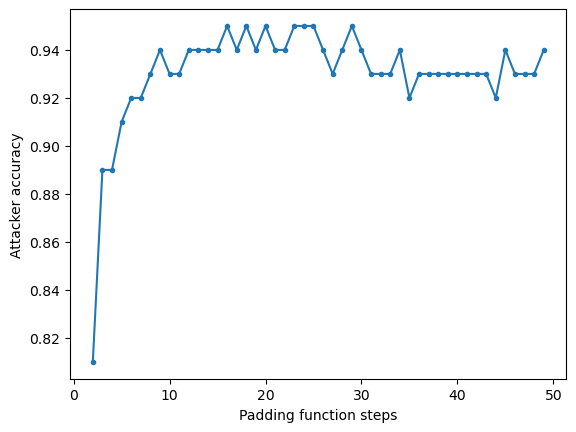

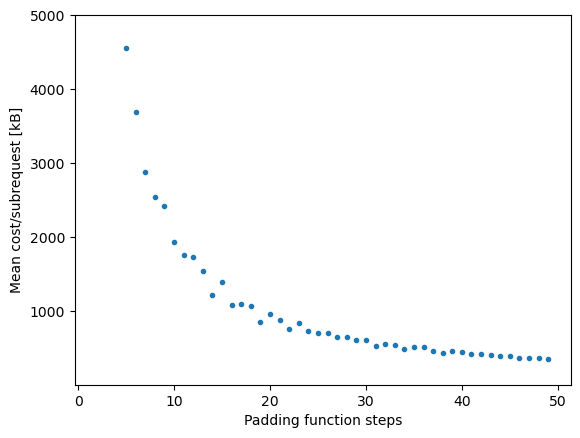

In [46]:
#print(padding_functions)
#print(clf_perfs)

to_plot = []
for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perfs[len(cuts)][0]['score']['f1score'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perfs[len(cuts)][0]['features'][:3]]
 
    to_plot.append([len(cuts), med_cost, acc])

len_cuts = [row[0] for row in to_plot]
med_costs = [row[1] for row in to_plot]
accs = [row[2] for row in to_plot]

plt.plot(len_cuts, accs, marker=".")
plt.ylabel("Attacker accuracy")
plt.xlabel("Padding function steps")
plt.show()
plt.scatter(len_cuts, med_costs, marker=".")
plt.ylim([1,5000])
plt.ylabel("Mean cost/subrequest [kB]")
plt.xlabel("Padding function steps")
plt.show()